# sklearn-assignment

### Bruno Luvizotto Carli

### IAA2021 - UFPR

Atividade proposta na disciplina de Linguagem de Programação Aplicada do curso de Especialização em Inteligência Artfical Aplicada da Universidade Federal do Paraná (UFPR).

### Professor: Alexander Robert Kutzke

# Original Exercise Author: Olivier Grisel

<olivier.grisel@ensta.org>

## License: Simplified BSD


Build a sentiment analysis / polarity model

Sentiment analysis can be casted as a binary text classification problem,
that is fitting a linear classifier on features extracted from the text
of the user messages so as to guess wether the opinion of the author is
positive or negative.

In this examples we will use a movie review dataset.





In [2]:
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [159]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable

In [74]:
# the training data folder must be passed as first argument
movie_reviews_data_folder = r"./data"
dataset = load_files(movie_reviews_data_folder, shuffle=False)
print("n_samples: %d" % len(dataset.data))

n_samples: 2000


#### Lets take a look at the data first.

A Pandas Data Frame will be handful here:

In [15]:
df = pd.DataFrame(
    data= np.c_[dataset.data, dataset.target],
    columns=['Data', 'Target']
)

df  # show information on jupyter notebook output

,Data,Target
0,b'plot : two teen couples go to a church party...,b'0'
1,b'the happy bastard\'s quick movie review \nda...,b'0'
2,"b""it is movies like these that make a jaded mo...",b'0'
3,"b' "" quest for camelot "" is warner bros . \' f...",b'0'
4,b'synopsis : a mentally unstable man undergoin...,b'0'
...,...,...
1995,"b""wow ! what a movie . \nit's everything a mov...",b'1'
1996,"b'richard gere can be a commanding actor , but...",b'1'
1997,"b'glory--starring matthew broderick , denzel w...",b'1'
1998,b'steven spielberg\'s second epic film on worl...,b'1'


In [124]:
# split the dataset in training and test set:
docs_train, docs_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.25, random_state=None)

In [106]:
# TASK: Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])

text_clf.fit(docs_train, y_train)

# Now we can build a function to extract the tokens from a string
def string_filter(text: str, clf: Callable = text_clf.predict) -> Tuple[str, List[str]]:
    """
    Remove all most/less common tokens from a text string.
    Returns a tuple in which the first position corresponds
    to the inputed string without the tokens and in the
    second position a list of the removed tokens.
    """
    tokens: List[str] = text.split()
    removed: List[str] = []

    for token in tokens:
        if clf([token])[0] == 0:
            removed.append(tokens.pop(tokens.index(token)))

    filtered: str = ' '.join(token for token in tokens).strip()
    return filtered, list(set(removed))

Now we can get both a filtered text and also a list of the filtered tokens

In [107]:
filtered_text, removed_tokens = string_filter('the quick brown fox jumps over the lazy dog')
print(filtered_text)
print(removed_tokens)

quick brown fox over lazy
['jumps', 'the', 'dog']


In [114]:
# TASK: Build a grid search to find out whether unigrams or bigrams are
# more useful.
# Fit the pipeline on the training set using grid search for the parameters

# i will be using the standartd example from the docs
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(docs_train, y_train)

for param_name in sorted(parameters.keys()):
    print(param_name, gs_clf.best_params_[param_name])

clf__alpha 0.01
tfidf__use_idf False
vect__ngram_range (1, 2)


Lets test our filter with this new classifier

In [128]:
filtered_text, removed_tokens = string_filter('the quick brown fox jumps over the lazy dog', gs_clf.predict)
print(filtered_text)
print(removed_tokens)

quick brown fox over lazy
['jumps', 'the', 'dog']


In [145]:
# TASK: print the cross-validated scores for the each parameters set
# explored by the grid search
print(gs_clf.best_score_)

0.8299999999999998


In [155]:
# TASK: Predict the outcome on the testing set and store it in a variable
# named y_predicted
y_predicted = gs_clf.predict(docs_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

              precision    recall  f1-score   support

         neg       0.95      0.98      0.97       255
         pos       0.98      0.95      0.96       245

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



In [157]:
# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[250   5]
 [ 13 232]]


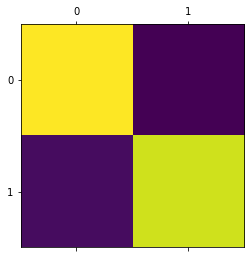

In [161]:
plt.matshow(cm)
plt.show()